In [1]:
import pandas as pd
movie_reviews = pd.read_csv("train.csv")
movie_reviews.isnull().values.any()
movie_reviews.shape


(156060, 4)

In [2]:
movie_reviews.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
import pandas as pd
test_reviews = pd.read_csv("test.csv")

test_reviews.isnull().values.any()

test_reviews.shape


(66292, 3)

In [4]:
test_reviews.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


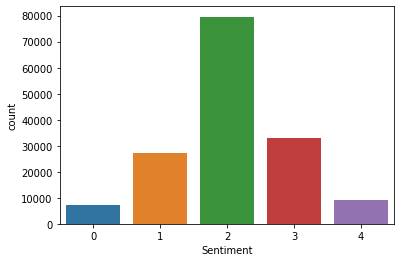

In [5]:
import seaborn as sns

sns.countplot(x='Sentiment', data=movie_reviews)

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers import LeakyReLU

Using TensorFlow backend.


In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dark1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
import re

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

stemmer=nltk.stem.WordNetLemmatizer()
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
   
    remove_tags(text)  
    # text = re.sub('[^a-zA-Z]', ' ', text)# Remove punctuations and numbers
    # text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)# Single character removal
    # text = re.sub(r'\s+', ' ', text)# Removing multiple spaces
    text = text.lower()# lowercase text  
    text = re.sub(REPLACE_BY_SPACE_RE,' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text    
    text = re.sub(BAD_SYMBOLS_RE,' ',text)# delete symbols which are in BAD_SYMBOLS_RE from text
    
    text = ' '.join(s for s in text.split() if s not in STOPWORDS)# delete stopwords from text  
    text = ' '.join(stemmer.lemmatize(token) for token in text.split())
    return text

In [10]:
X = []
sentences = list(movie_reviews['Phrase'])
for sen in sentences:
    X.append(text_prepare(sen))

In [11]:
X[8]

'escapade'

In [12]:
import numpy as np

Y=movie_reviews['Sentiment']
Y = np.array(Y)
Y=np.array(list(Y))

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [14]:
np.count_nonzero(Y_train == 2)

63943

In [15]:
np.count_nonzero(Y_test == 2)

15639

In [16]:
np.count_nonzero(Y_train == 1)

21746

In [17]:
np.count_nonzero(Y_test == 1)

5527

In [18]:
np.count_nonzero(Y_train == 0)

5656

In [19]:
np.count_nonzero(Y_test == 0)

1416

In [20]:
np.count_nonzero(Y_train == 3)

26220

In [21]:
np.count_nonzero(Y_test == 3)

6707

In [22]:
np.count_nonzero(Y_train == 4)

7283

In [23]:
np.count_nonzero(Y_test == 4)

1923

In [24]:
from collections import defaultdict

words_counts = defaultdict(int)
for text in X_train:
    for word in text.split():
        words_counts[word] += 1

In [25]:
#print(words_counts)

In [26]:
#print(len(words_counts))

In [27]:
DICT_SIZE = 9632
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = {p[0]:i for i,p in enumerate(most_common_words[:DICT_SIZE])}
def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    for word in text.split():
        if word in words_to_index:
            result_vector[words_to_index[word]] += 1
    return result_vector


In [28]:
#print(most_common_words)

In [29]:
from scipy import sparse as sp_sparse
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])


X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])


In [30]:
print('X_train shape ', X_train_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (124848, 9632)
X_test shape  (31212, 9632)


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
def tfidf_features(X_train, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(min_df=10,max_df=0.80,ngram_range=(1,2))
    X_train = tfidf_vectorizer.fit_transform(X_train)   
    X_test = tfidf_vectorizer.transform(X_test)
    return X_train,X_test, tfidf_vectorizer.vocabulary_

In [33]:
X_train_tfidf,X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [34]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_tk = tokenizer.texts_to_sequences(X_train)
X_test_tk = tokenizer.texts_to_sequences(X_test)

In [35]:
print(X_train[3]) 

somewhere sling blade south heaven west hell


In [36]:
X_train_tk[3]

[1016, 9965, 958, 851, 1004, 1666, 723]

In [37]:
maxlen=20
X_train_tk = pad_sequences(X_train_tk, padding='post', maxlen=maxlen)
X_test_tk = pad_sequences(X_test_tk, padding='post', maxlen=maxlen)

In [38]:
X_train_tk[3]

array([1016, 9965,  958,  851, 1004, 1666,  723,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [39]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [40]:
vocab_size = len(tokenizer.word_index)+1

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [41]:
from keras.utils import to_categorical
Y_train_oh = to_categorical(Y_train)
Y_test_oh= to_categorical(Y_test)
print(Y_train_oh[3])

[0. 0. 1. 0. 0.]


In [42]:
print( len(embedding_matrix))
print(len(embedding_matrix[0]))

13759
100


In [43]:
class_weight = {0: 8.,
                1: 3.,
                2: 1.,
                3: 3.,
                4: 8.}

In [77]:
from sklearn.linear_model import LogisticRegression

In [78]:
model = LogisticRegression()
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)



C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [79]:
from sklearn import metrics

In [80]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[  340,   625,   417,    30,     4],
       [  198,  1849,  3238,   227,    15],
       [   35,   718, 14027,   811,    48],
       [    7,   168,  3414,  2767,   351],
       [    1,    21,   352,   953,   596]], dtype=int64)

In [81]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred_mybag)

0.6272907855952838

In [82]:
model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)



In [83]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[  223,   709,   438,    45,     1],
       [  102,  1774,  3396,   245,    10],
       [   25,   662, 14021,   894,    37],
       [    4,   129,  3400,  2974,   200],
       [    0,    23,   367,  1134,   399]], dtype=int64)

In [84]:
accuracy_score(Y_test, Y_pred_tfidf)

0.6212674612328591

In [85]:
model.fit(X_train_tk,Y_train)

Y_pred_tfidf=model.predict(X_test_tk)



C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [86]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[    8,   102,  1249,    54,     3],
       [   13,   269,  5071,   166,     8],
       [    9,   243, 15214,   171,     2],
       [   15,   260,  6240,   187,     5],
       [    6,   111,  1737,    64,     5]], dtype=int64)

In [87]:
accuracy_score(Y_test, Y_pred_tfidf)

0.5024669998718442

In [88]:
from sklearn.svm import SVC

In [89]:
model = SVC(C=100)
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)


C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [90]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[   13,   439,   920,    44,     0],
       [    5,   745,  4570,   207,     0],
       [    4,   306, 14853,   474,     2],
       [    2,   135,  4847,  1715,     8],
       [    0,    24,   919,   934,    46]], dtype=int64)

In [91]:
accuracy_score(Y_test, Y_pred_mybag)

0.5565808022555427

In [92]:
model = SVC(C=100)
model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)


C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [93]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[    0,     0,  1415,     1,     0],
       [    0,     0,  5517,    10,     0],
       [    0,     0, 15626,    13,     0],
       [    0,     0,  6672,    35,     0],
       [    0,     0,  1911,    12,     0]], dtype=int64)

In [94]:
accuracy_score(Y_test, Y_pred_tfidf)

0.5017621427656029

In [120]:
model.fit(X_train_tk,Y_train)

Y_pred_tfidf=model.predict(X_test_tk)



In [121]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[  514,   549,   224,    93,    36],
       [  581,  2372,  2028,   440,   106],
       [  305,  2026, 11282,  1825,   201],
       [  124,   547,  2574,  2821,   641],
       [   57,   136,   310,   831,   589]], dtype=int64)

In [122]:
accuracy_score(Y_test, Y_pred_tfidf)

0.5631808278867102

In [98]:
from sklearn.ensemble import RandomForestClassifier

In [99]:
model = RandomForestClassifier(100)
model.fit(X_train_mybag,Y_train)
Y_pred_rf=model.predict(X_test_mybag)

model.score(X_test_mybag,Y_test)

0.6368383954889145

In [100]:
from sklearn import metrics

In [101]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_rf)
cnf_matrix

array([[  528,   664,   209,    11,     4],
       [  451,  2630,  2238,   194,    14],
       [  113,  1372, 12528,  1545,    81],
       [    4,   164,  2423,  3378,   738],
       [    2,     6,   175,   927,   813]], dtype=int64)

In [102]:
accuracy_score(Y_test, Y_pred_rf)

0.6368383954889145

In [103]:
model = RandomForestClassifier(100)
model.fit(X_train_tfidf,Y_train)
Y_pred_tfidf=model.predict(X_test_tfidf)

model.score(X_test_tfidf,Y_test)

0.6336665385108292

In [104]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[  513,   638,   244,    18,     3],
       [  442,  2543,  2311,   218,    13],
       [  114,  1378, 12537,  1526,    84],
       [    6,   172,  2417,  3380,   732],
       [    3,     9,   167,   939,   805]], dtype=int64)

In [105]:
accuracy_score(Y_test, Y_pred_tfidf)

0.6336665385108292

In [125]:
model.fit(X_train_tk,Y_train)

Y_pred_tfidf=model.predict(X_test_tk)



In [126]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[  513,   559,   217,   101,    26],
       [  575,  2387,  2020,   434,   111],
       [  298,  2014, 11265,  1857,   205],
       [  131,   549,  2558,  2825,   644],
       [   51,   142,   318,   835,   577]], dtype=int64)

In [127]:
accuracy_score(Y_test, Y_pred_tfidf)

0.5628283993335896

In [109]:
from sklearn import tree

In [110]:
model= tree.DecisionTreeClassifier()

In [111]:
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)


In [112]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[  621,   606,   170,    13,     6],
       [  637,  2757,  1957,   158,    18],
       [  179,  1784, 12141,  1452,    83],
       [   16,   228,  2551,  3266,   646],
       [    5,    22,   201,   980,   715]], dtype=int64)

In [113]:
accuracy_score(Y_test, Y_pred_mybag)

0.6247597078046905

In [114]:
model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)



In [115]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[  587,   597,   186,    42,     4],
       [  630,  2621,  2044,   208,    24],
       [  201,  1815, 12063,  1471,    89],
       [   32,   291,  2564,  3197,   623],
       [   14,    40,   225,   957,   687]], dtype=int64)

In [116]:
accuracy_score(Y_test, Y_pred_tfidf)

0.6137062668204537

In [128]:
model.fit(X_train_tk,Y_train)

Y_pred_tfidf=model.predict(X_test_tk)



In [129]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[  515,   556,   212,    97,    36],
       [  578,  2384,  2019,   448,    98],
       [  319,  2032, 11251,  1821,   216],
       [  126,   542,  2585,  2817,   637],
       [   53,   137,   317,   832,   584]], dtype=int64)

In [130]:
accuracy_score(Y_test, Y_pred_tfidf)

0.5623157759835961

In [211]:
from keras import metrics

In [215]:
from sklearn import metrics
from sklearn.metrics import recall_score  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
import matplotlib. pyplot as plt

In [ ]:
#word embedding

In [161]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(320, activation='tanh'))
model.add(Dense(160))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.6))


model.add(Dense(80, activation='tanh'))
model.add(Dense(40))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))


model.add(Dense(20, activation='tanh'))
model.add(Dense(10))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))

model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 20, 100)           1375900   
_________________________________________________________________
flatten_3 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 320)               640320    
_________________________________________________________________
dense_55 (Dense)             (None, 160)               51360     
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 160)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 80)              

In [162]:
history = model.fit(X_train_tk, Y_train_oh, batch_size=80, epochs=6, verbose=1, validation_split=0.2,class_weight=class_weight)

Train on 99878 samples, validate on 24970 samples
Epoch 1/6
99878/99878 [==============================] - 34s 336us/step - loss: 3.6069 - acc: 0.3190 - recall_9: 0.7151 - precision_9: 0.2844 - val_loss: 3.2201 - val_acc: 0.4607 - val_recall_9: 0.7529 - val_precision_9: 0.3441
Epoch 2/6
99878/99878 [==============================] - 33s 330us/step - loss: 3.3286 - acc: 0.4528 - recall_9: 0.6835 - precision_9: 0.3548 - val_loss: 3.1867 - val_acc: 0.5017 - val_recall_9: 0.7453 - val_precision_9: 0.4012
Epoch 3/6
99878/99878 [==============================] - 33s 330us/step - loss: 3.2399 - acc: 0.4768 - recall_9: 0.6871 - precision_9: 0.3775 - val_loss: 3.1281 - val_acc: 0.5346 - val_recall_9: 0.7178 - val_precision_9: 0.4210
Epoch 4/6
99878/99878 [==============================] - 33s 331us/step - loss: 3.1753 - acc: 0.4910 - recall_9: 0.6803 - precision_9: 0.3922 - val_loss: 3.0964 - val_acc: 0.5358 - val_recall_9: 0.7362 - val_precision_9: 0.4189
Epoch 5/6
99878/99878 [===============

In [164]:
pr = model.predict(X_test_tk)

In [165]:
cnf_matrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))
print(cnf_matrix)

[[1104  126   53  132    1]
 [2987  942  855  743    0]
 [2534 2374 8425 2306    0]
 [ 798  572 1501 3835    1]
 [ 126   82  109 1604    2]]


In [166]:
recall_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.4584134307317698

In [167]:
mean_squared_error(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

1.247533000128156

In [168]:
precision_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.4584134307317698

In [169]:
accuracy_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.4584134307317698

In [170]:
 import matplotlib. pyplot as plt

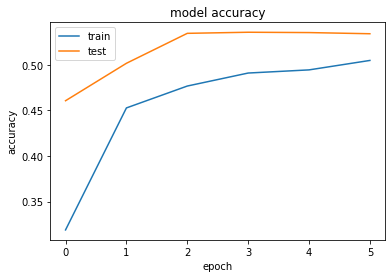

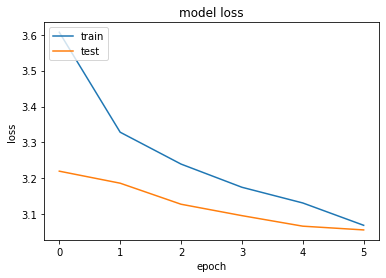

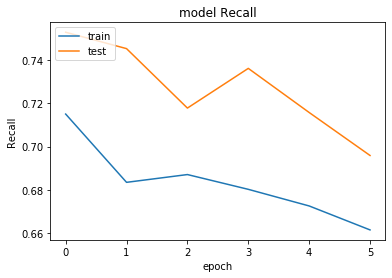

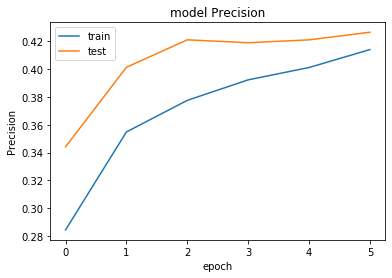

In [171]:
    
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_9'])
plt.plot(history.history['val_recall_9'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_9'])
plt.plot(history.history['val_precision_9'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [60]:
#cnn


In [174]:
from keras.layers import Activation,Conv1D,MaxPooling1D,Flatten
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

#model_cnn.add(MaxPooling1D())

model.add(Conv1D(320,2, activation='tanh'))
model.add(Conv1D(160,2))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D())
model.add(Dropout(0.6))


model.add(Conv1D(80,2, activation='tanh'))
model.add(Conv1D(40,2))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D())
model.add(Dropout(0.4))


model.add(Conv1D(20,2, activation='tanh'))
model.add(Conv1D(10,2))
model.add(LeakyReLU(alpha=0.1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.4))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 20, 100)           1375900   
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 19, 320)           64320     
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 18, 160)           102560    
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 18, 160)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 9, 160)            0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 9, 160)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 8, 80)           

In [175]:
history = model.fit(X_train_tk, Y_train_oh, batch_size=80, epochs=6, verbose=1, validation_split=0.2,class_weight=class_weight)

Train on 99878 samples, validate on 24970 samples
Epoch 1/6
99878/99878 [==============================] - 70s 696us/step - loss: 3.5241 - acc: 0.4135 - recall_10: 0.6520 - precision_10: 0.3225 - val_loss: 3.1188 - val_acc: 0.4624 - val_recall_10: 0.6709 - val_precision_10: 0.3751
Epoch 2/6
99878/99878 [==============================] - 72s 719us/step - loss: 3.2758 - acc: 0.4563 - recall_10: 0.6145 - precision_10: 0.3809 - val_loss: 3.0557 - val_acc: 0.5115 - val_recall_10: 0.6960 - val_precision_10: 0.4271
Epoch 3/6
99878/99878 [==============================] - 74s 741us/step - loss: 3.2043 - acc: 0.4640 - recall_10: 0.5989 - precision_10: 0.3969 - val_loss: 3.0273 - val_acc: 0.5083 - val_recall_10: 0.6939 - val_precision_10: 0.4215
Epoch 4/6
99878/99878 [==============================] - 67s 674us/step - loss: 3.1490 - acc: 0.4657 - recall_10: 0.5995 - precision_10: 0.4041 - val_loss: 3.0521 - val_acc: 0.4924 - val_recall_10: 0.6946 - val_precision_10: 0.4245
Epoch 5/6
99878/99878 

In [177]:
pr = model.predict(X_test_tk)

In [178]:
cnf_matrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))
print(cnf_matrix)

[[1152  120   63   81    0]
 [3079  853 1002  593    0]
 [2361 1783 8807 2688    0]
 [ 919  513 1245 4029    1]
 [ 142   77   72 1629    3]]


In [179]:
recall_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.4755863129565552

In [180]:
mean_squared_error(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

1.2149173394848136

In [181]:
precision_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.4755863129565552

In [182]:
accuracy_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.4755863129565552

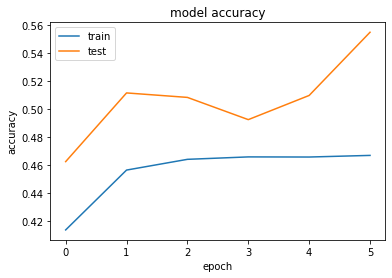

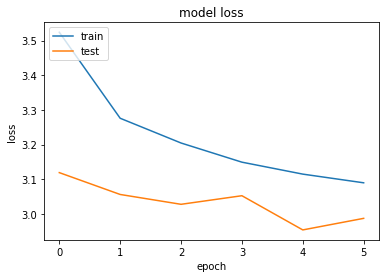

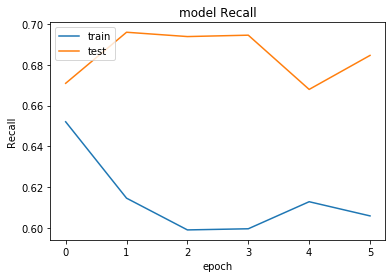

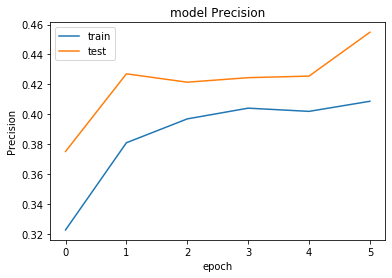

In [184]:
    
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_10'])
plt.plot(history.history['val_recall_10'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_10'])
plt.plot(history.history['val_precision_10'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [48]:
#lstm

In [186]:
from keras.layers import Embedding,LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)


model.add(LSTM(320,return_sequences = True, activation='tanh'))
model.add(LSTM(160,return_sequences = True))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.6))


model.add(LSTM(80,return_sequences = True, activation='tanh'))
model.add(LSTM(40,return_sequences = True))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))


model.add(LSTM(20,return_sequences = True, activation='tanh'))
model.add(LSTM(10,return_sequences = False))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))

model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())




Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 20, 100)           1375900   
_________________________________________________________________
lstm_11 (LSTM)               (None, 20, 320)           538880    
_________________________________________________________________
lstm_12 (LSTM)               (None, 20, 160)           307840    
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 20, 160)           0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 20, 160)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 20, 80)            77120     
_________________________________________________________________
lstm_14 (LSTM)               (None, 20, 40)          

In [188]:
history = model.fit(X_train_tk, Y_train_oh, batch_size=80, epochs=6, verbose=1, validation_split=0.2,class_weight=class_weight)

Train on 99878 samples, validate on 24970 samples
Epoch 1/6
99878/99878 [==============================] - 664s 7ms/step - loss: 3.7623 - acc: 0.2374 - recall_11: 0.7765 - precision_11: 0.2514 - val_loss: 3.5229 - val_acc: 0.2485 - val_recall_11: 0.7785 - val_precision_11: 0.2818
Epoch 2/6
99878/99878 [==============================] - 633s 6ms/step - loss: 3.4499 - acc: 0.3304 - recall_11: 0.8049 - precision_11: 0.2966 - val_loss: 3.2900 - val_acc: 0.4891 - val_recall_11: 0.8688 - val_precision_11: 0.3086
Epoch 3/6
99878/99878 [==============================] - 648s 6ms/step - loss: 3.2423 - acc: 0.4692 - recall_11: 0.7898 - precision_11: 0.3349 - val_loss: 3.0150 - val_acc: 0.5347 - val_recall_11: 0.7820 - val_precision_11: 0.3794
Epoch 4/6
99878/99878 [==============================] - 640s 6ms/step - loss: 3.0403 - acc: 0.5066 - recall_11: 0.6956 - precision_11: 0.4112 - val_loss: 2.8943 - val_acc: 0.5506 - val_recall_11: 0.7071 - val_precision_11: 0.4652
Epoch 5/6
99878/99878 [===

In [189]:
pr = model.predict(X_test_tk)

In [192]:
cnf_matrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))
print(cnf_matrix)

[[1180  143   45   48    0]
 [2960 1211  947  409    0]
 [2574 1895 8952 2218    0]
 [ 846  369 1095 4397    0]
 [  72   28   40 1783    0]]


In [193]:
recall_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.5042932205561963

In [194]:
mean_squared_error(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

1.0969819300269128

In [195]:
precision_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.5042932205561963

In [196]:
accuracy_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.5042932205561963

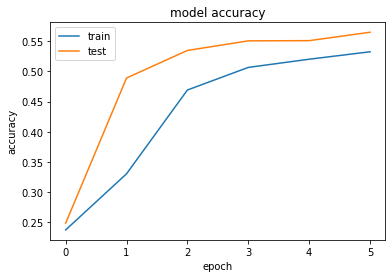

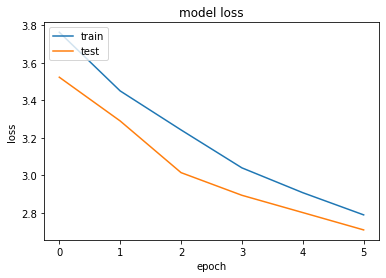

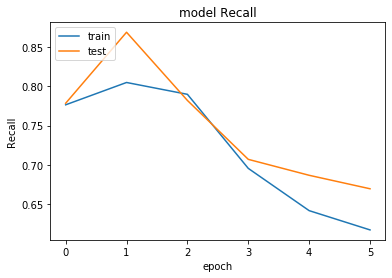

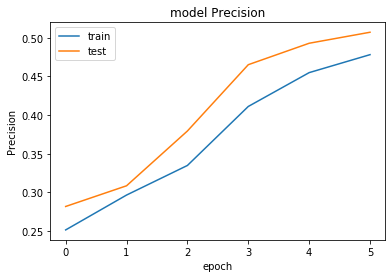

In [197]:
    
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_11'])
plt.plot(history.history['val_recall_11'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_11'])
plt.plot(history.history['val_precision_11'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [65]:
#tfidf

In [200]:
model = Sequential()

model.add(Dense(320,input_shape= (16694,), activation='tanh'))
model.add(Dense(16))
model.add(Dropout(0.6))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(80, activation='tanh'))
model.add(Dense(40))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))


model.add(Dense(20, activation='tanh'))
model.add(Dense(10))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 320)               5342400   
_________________________________________________________________
dense_72 (Dense)             (None, 16)                5136      
_________________________________________________________________
dropout_52 (Dropout)         (None, 16)                0         
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 80)                1360      
_________________________________________________________________
dense_74 (Dense)             (None, 40)                3240      
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 40)              

In [201]:
history = model.fit(X_train_tfidf, Y_train_oh, batch_size=80, epochs=6, verbose=1, validation_split=0.2,class_weight=class_weight)

Train on 99878 samples, validate on 24970 samples
Epoch 1/6
99878/99878 [==============================] - 241s 2ms/step - loss: 3.4778 - acc: 0.3646 - recall_12: 0.7161 - precision_12: 0.3115 - val_loss: 2.9629 - val_acc: 0.4767 - val_recall_12: 0.8152 - val_precision_12: 0.3530
Epoch 2/6
99878/99878 [==============================] - 214s 2ms/step - loss: 2.9821 - acc: 0.4882 - recall_12: 0.8037 - precision_12: 0.3767 - val_loss: 2.8331 - val_acc: 0.5405 - val_recall_12: 0.8021 - val_precision_12: 0.3954
Epoch 3/6
99878/99878 [==============================] - 224s 2ms/step - loss: 2.8332 - acc: 0.5219 - recall_12: 0.7961 - precision_12: 0.4058 - val_loss: 2.7985 - val_acc: 0.5529 - val_recall_12: 0.8064 - val_precision_12: 0.4218
Epoch 4/6
99878/99878 [==============================] - 232s 2ms/step - loss: 2.7562 - acc: 0.5242 - recall_12: 0.7814 - precision_12: 0.4179 - val_loss: 2.7971 - val_acc: 0.5660 - val_recall_12: 0.7949 - val_precision_12: 0.4245
Epoch 5/6
99878/99878 [===

In [203]:
pr = model.predict(X_test_tfidf)

In [204]:
cnf_matrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))
print(cnf_matrix)

[[1181  122   77   36    0]
 [2673 1342 1207  305    0]
 [1700 3518 8374 2047    0]
 [ 193  403 2227 3884    0]
 [  14   15  160 1734    0]]


In [205]:
recall_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.4735678585159554

In [206]:
mean_squared_error(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.8499295142893759

In [207]:
precision_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.4735678585159554

In [208]:
accuracy_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.4735678585159554

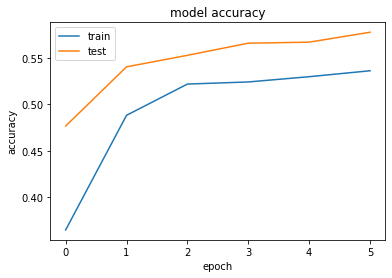

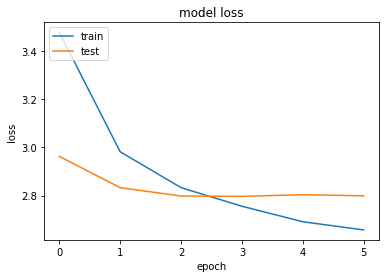

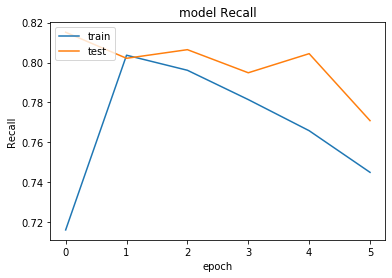

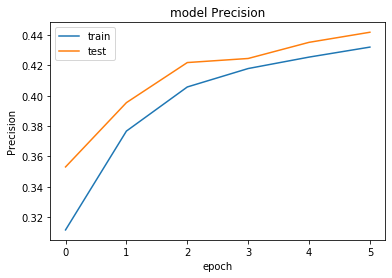

In [209]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_12'])
plt.plot(history.history['val_recall_12'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_12'])
plt.plot(history.history['val_precision_12'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [71]:
#bag of words

In [212]:
model = Sequential()

model.add(Dense(320,input_shape= (9632,), activation='tanh'))
model.add(Dense(160))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.6))


model.add(Dense(80, activation='tanh'))
model.add(Dense(40))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))

model.add(Dense(20, activation='tanh'))
model.add(Dense(10))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))

model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 320)               3082560   
_________________________________________________________________
dense_86 (Dense)             (None, 160)               51360     
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 160)               0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 80)                12880     
_________________________________________________________________
dense_88 (Dense)             (None, 40)                3240      
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, 40)              

In [213]:
history = model.fit(X_train_mybag, Y_train_oh, batch_size=80, epochs=6, verbose=1, validation_split=0.2,class_weight=class_weight)

Train on 99878 samples, validate on 24970 samples
Epoch 1/6
99878/99878 [==============================] - 137s 1ms/step - loss: 3.4195 - acc: 0.2757 - recall_13: 0.8356 - precision_13: 0.2879 - val_loss: 2.9349 - val_acc: 0.3181 - val_recall_13: 0.8259 - val_precision_13: 0.3417
Epoch 2/6
99878/99878 [==============================] - 147s 1ms/step - loss: 2.9208 - acc: 0.4479 - recall_13: 0.8208 - precision_13: 0.3707 - val_loss: 2.7681 - val_acc: 0.5224 - val_recall_13: 0.8342 - val_precision_13: 0.3957
Epoch 3/6
99878/99878 [==============================] - 157s 2ms/step - loss: 2.7502 - acc: 0.4987 - recall_13: 0.8015 - precision_13: 0.4167 - val_loss: 2.7082 - val_acc: 0.5125 - val_recall_13: 0.7804 - val_precision_13: 0.4149
Epoch 4/6
99878/99878 [==============================] - 168s 2ms/step - loss: 2.6440 - acc: 0.5192 - recall_13: 0.7568 - precision_13: 0.4441 - val_loss: 2.6679 - val_acc: 0.5577 - val_recall_13: 0.7618 - val_precision_13: 0.4496
Epoch 5/6
99878/99878 [===

In [214]:
pr = model.predict(X_test_mybag)

In [216]:
cnf_matrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))
print(cnf_matrix)

[[1179  147   66   17    7]
 [2532 1421 1320  221   33]
 [1475 2202 9709 2113  140]
 [ 376  306 1803 3428  794]
 [  55   24   94  852  898]]


In [217]:
recall_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.5329680891964629

In [218]:
mean_squared_error(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.8334294502114571

In [219]:
precision_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.5329680891964629

In [220]:
accuracy_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.5329680891964629

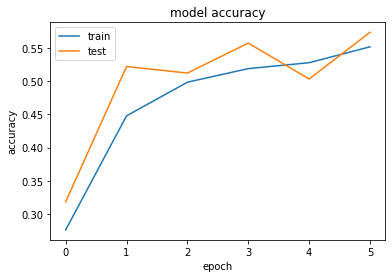

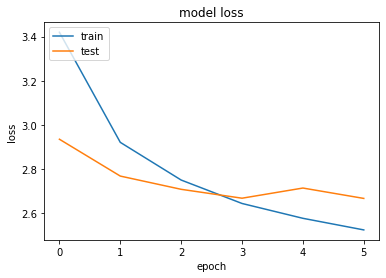

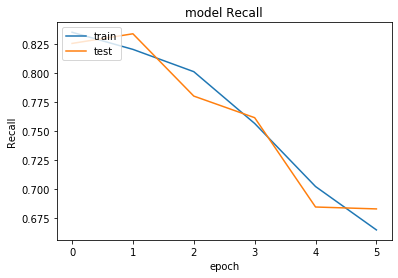

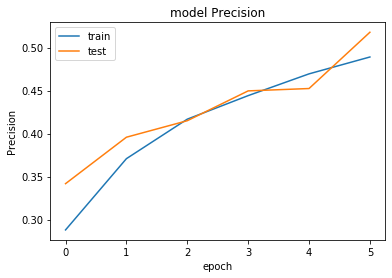

In [221]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_13'])
plt.plot(history.history['val_recall_13'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_13'])
plt.plot(history.history['val_precision_13'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [33]:
#tfidf_reversed_vocab

In [34]:
print( X_train_tfidf[1].shape)

(1, 16694)


In [35]:
print( X_train_mybag[1].shape)

(1, 9632)


In [36]:
X_train_tfidf_3d=X_train_tfidf.toarray()

In [37]:
print(X_train_tfidf_3d.shape)

(124848, 16694)


In [38]:
firstghalf=X_train_tfidf_3d[:62424,:]
secondhalf=X_train_tfidf_3d[62424:,:]

In [39]:
secondhalf.shape

(62424, 16694)

In [40]:
from numpy import  newaxis
firstghalf=firstghalf[:,:,newaxis]
secondhalf=secondhalf[:,:,newaxis]

In [41]:
X_train_tfidf_3d=np.concatenate((firstghalf,secondhalf))

In [44]:
print(X_train_tfidf_3d.shape)

(124848, 16694, 1)


In [45]:
X_test_tfidf_3d=X_test_tfidf.toarray()

In [46]:
print(X_test_tfidf_3d.shape)

(31212, 16694)


In [47]:
from numpy import  newaxis
X_test_tfidf_3d=X_test_tfidf_3d[:,:,newaxis]

In [48]:
print(X_test_tfidf_3d.shape)

(31212, 16694, 1)


In [51]:
#X_train_mybag_3d=X_train_mybag.toarray()
firstghalf=X_train_tfidf[:62424,:]
secondhalf=X_train_tfidf[62424:,:]
firstghalf =firstghalf.toarray()
secondhalf=secondhalf.toarray()

MemoryError: Unable to allocate 7.76 GiB for an array with shape (62424, 16694) and data type float64

In [ ]:
print(X_train_mybag_3d.shape)

In [ ]:

X_train_mybag_3d=X_train_mybag_3d[:,:,newaxis]

In [ ]:
print(X_train_mybag_3d.shape)

In [ ]:
X_test_mybag_3d=X_test_mybag.toarray()

In [ ]:
print(X_test_mybag_3d.shape)

In [ ]:

X_test_mybag_3d=X_test_mybag_3d[:,:,newaxis]

In [ ]:
print(X_test_mybag_3d.shape)